# Project Title :
# **StudyBuddy: A Multi-Agent Learning Companion** 

# *Subtitle* : **Personalized topic breakdowns, flashcards & revision plans fully powered by multi-agent AI.**

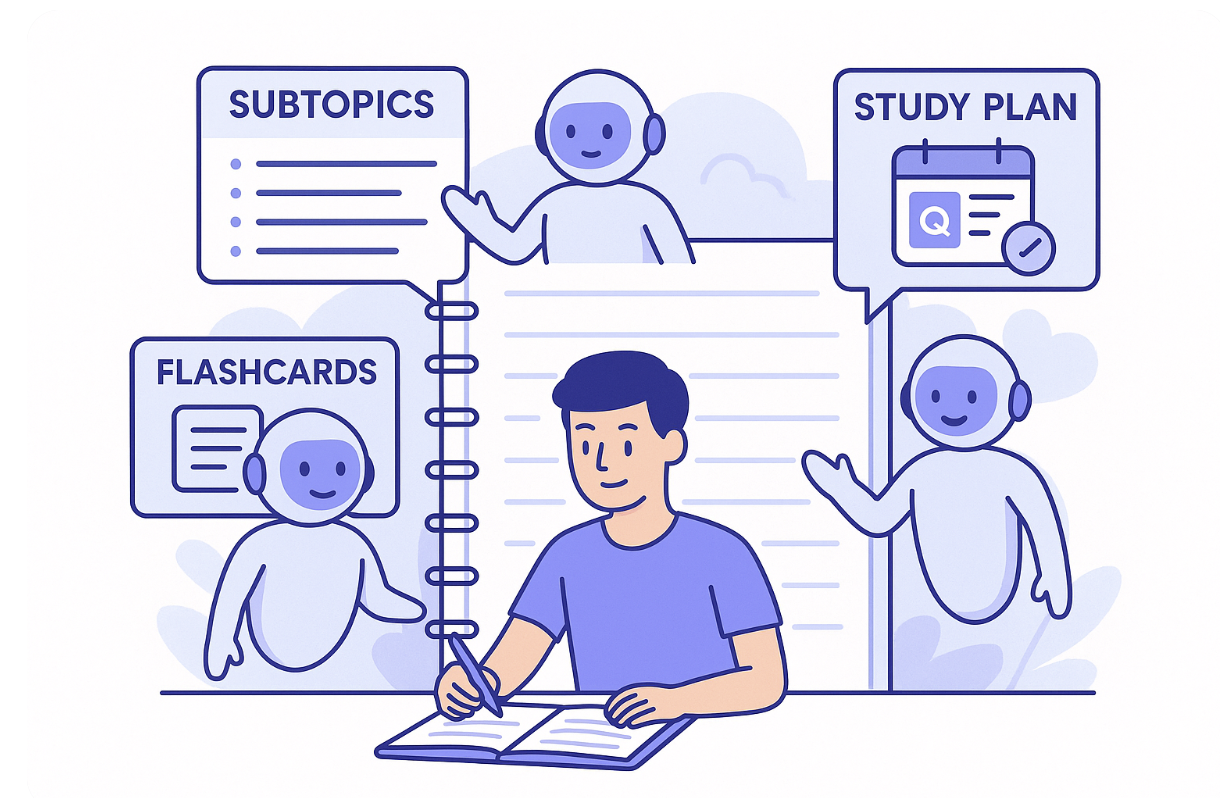
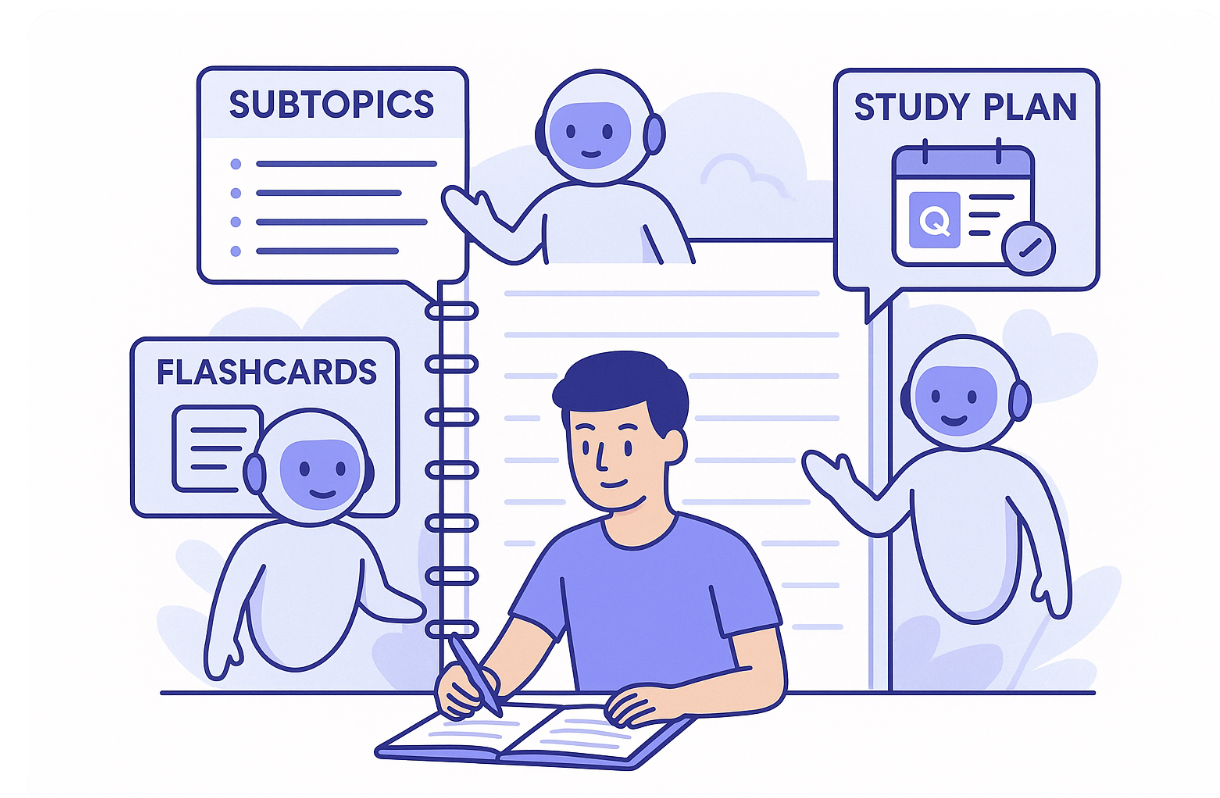

# Submission Track : **Agents for Good**

# **Project description**



**StudyBuddy is a lightweight, easy-to-understand multi-agent system built using the Google Agent Development Kit (ADK).Its goal is to help students learn any topic quickly by automatically generating a structured “study package” containing:**

	1.	Subtopics – The topic is divided into clean mini-modules.
	2.	Flashcards – Key Q&A pairs for quick revision.
	3.	3-Day Revision Plan – A simple and actionable schedule.

**The system is intentionally designed to be minimal, transparent, and easy to debug, making it perfect for beginners learning multi-agent orchestration. Each stage is handled by an individual LlmAgent:**

	•	TopicBreakdownAgent → Turns a topic into 4-7 subtopics
	•	FlashcardAgent → Generates 5 simple flashcards
	•	RevisionPlannerAgent → Creates a 3-day learning plan

**Overall, StudyBuddy demonstrates how powerful multi-agent workflows can be even in their simplest form. By combining clear agent roles, lightweight memory, and a deterministic orchestrator, the system transforms a single user query into an organized learning package without unnecessary complexity. This project showcases the core strengths of ADK structured reasoning, modular agent design, and clean event-driven orchestration in a way that is easy to understand, replicate, and extend. Whether used as a learning tool or as a foundation for more advanced pipelines, StudyBuddy highlights how accessible multi-agent AI systems can be when built with clarity and purpose.**

In [234]:
# ============================
# BLOCK 1 — IMPORTS & ENV SETUP
# ============================
import os
import json
from dataclasses import dataclass, field
from typing import Dict, Any
from kaggle_secrets import UserSecretsClient
from google.adk.agents import LlmAgent, BaseAgent
from google.adk.runners import InMemoryRunner
from google.adk.events import Event
from google.adk.models.google_llm import Gemini
from google.genai import types


In [235]:
# -----------------------------
# Load GOOGLE_API_KEY from Kaggle Secrets
# -----------------------------
try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ API Key loaded successfully.")
except Exception as e:
    print("❌ ERROR: Add GOOGLE_API_KEY to Kaggle Secrets.", e)


✅ API Key loaded successfully.


In [236]:
# -----------------------------
# Configure Retry
# -----------------------------
retry_config = types.HttpRetryOptions(
    attempts=5,
    exp_base=2,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],
)
print("🔁 Retry config set.")

🔁 Retry config set.


In [237]:
# -----------------------------
# Shared LLM Model
# -----------------------------
shared_model = Gemini(
    model="gemini-2.0-flash-lite",
    retry_options=retry_config
)
print("Shared model initialized.")


Shared model initialized.


In [238]:
# ============================
# SIMPLE MEMORY STORE
# ============================
@dataclass
class StudyBuddyMemory:
    last_topic: str = ""
    last_subtopics: str = ""
    last_flashcards: str = ""
    last_revision_plan: str = ""
    logs: list = field(default_factory=list)
    
    def add_log(self, text: str):
        self.logs.append(text)
        
    def save_logs_to_file(self, filename="studybuddy_logs.txt"):
        with open(filename, "w", encoding="utf-8") as f:
            for log in self.logs:
                f.write(log + "\n")
        print(f"Logs saved to: {filename}")

In [239]:
# ============================
# AGENT FACTORY
# ============================
def make_agent(name, instruction, output_key, tools=None):
    """Creates a simple LlmAgent with shared model + tools."""
    return LlmAgent(
        name=name,
        model=shared_model,
        instruction=instruction,
        tools=tools or [],
        output_key=output_key
    )



In [240]:
# ============================
# DEFINE AGENTS
# ============================
topic_breakdown_agent = make_agent(
    name="TopicBreakdownAgent",
    instruction="""
    Break the given topic into 4–7 subtopics.
    Use clean bullet points only.
    Keep it beginner-friendly.
    """,
    output_key="subtopics"
)

In [241]:
flashcard_agent = make_agent(
    name="FlashcardAgent",
    instruction="""
    Generate 5 high-quality flashcards based on the subtopics: {subtopics}
    Format:
    Q: ...
    A: ...
    Keep answers short and clear.
    """,
    output_key="flashcards"
)

In [242]:
revision_planner_agent = make_agent(
    name="RevisionPlannerAgent",
    instruction="""
    Create a simple 3-day revision plan based on:
    Subtopics: {subtopics}
    Flashcards: {flashcards}
    
    Format strictly:
    Day 1: ...
    Day 2: ...
    Day 3: ...
    No extra text.
    """,
    output_key="revision_plan"
)


In [243]:
# ============================
# GLOBAL MEMORY
# ============================
GLOBAL_MEMORY = None

In [244]:

# ============================
# ORCHESTRATOR
# ============================
class StudyBuddyOrchestrator(BaseAgent):
    def __init__(self, **kwargs):
        super().__init__(
            name="StudyBuddyOrchestrator",
            sub_agents=[
                topic_breakdown_agent,
                flashcard_agent,
                revision_planner_agent
            ],
            **kwargs
        )
    
    async def _run_async_impl(self, ctx):
        global GLOBAL_MEMORY
        
        # Extract user input from context
        user_content = ctx.user_content
        if user_content and user_content.parts:
            user_text = user_content.parts[0].text
        else:
            user_text = "No input provided"
        
        print("\n=== USER INPUT ===")
        print(user_text)
        
        if GLOBAL_MEMORY:
            GLOBAL_MEMORY.last_topic = user_text
            GLOBAL_MEMORY.add_log(f"User query: {user_text}")
        
        # STEP 1: Topic Breakdown
        print("\n🔍 Running Topic Breakdown...")
        async for event in topic_breakdown_agent.run_async(ctx):
            yield event
        
        subtopics = ctx.session.state.get("subtopics", "")
        print("\n=== SUBTOPICS ===")
        print(subtopics)
        
        if GLOBAL_MEMORY:
            GLOBAL_MEMORY.last_subtopics = subtopics
            GLOBAL_MEMORY.add_log("Subtopics generated")
        
        # STEP 2: Flashcards
        print("\n🃏 Generating Flashcards...")
        async for event in flashcard_agent.run_async(ctx):
            yield event
        
        flashcards = ctx.session.state.get("flashcards", "")
        print("\n=== FLASHCARDS ===")
        print(flashcards)
        
        if GLOBAL_MEMORY:
            GLOBAL_MEMORY.last_flashcards = flashcards
            GLOBAL_MEMORY.add_log("Flashcards generated")
        
        # STEP 3: Revision Plan
        print("\n📅 Creating Revision Plan...")
        async for event in revision_planner_agent.run_async(ctx):
            yield event
        
        plan = ctx.session.state.get("revision_plan", "")
        print("\n=== REVISION PLAN ===")
        print(plan)
        
        if GLOBAL_MEMORY:
            GLOBAL_MEMORY.last_revision_plan = plan
            GLOBAL_MEMORY.add_log("Revision plan created")
        
        # STEP 4: Compile Final Output
        final_output = f"""
╔══════════════════════════════════════════════════════════════╗
║                    📚 STUDY PACKAGE                          ║
╚══════════════════════════════════════════════════════════════╝

📌 TOPIC: {user_text}

─────────────────────────────────────────────────────────────────
🔍 SUBTOPICS:
─────────────────────────────────────────────────────────────────
{subtopics}

─────────────────────────────────────────────────────────────────
🃏 FLASHCARDS:
─────────────────────────────────────────────────────────────────
{flashcards}

─────────────────────────────────────────────────────────────────
📅 3-DAY REVISION PLAN:
─────────────────────────────────────────────────────────────────
{plan}

╚══════════════════════════════════════════════════════════════╝
"""
        
        print("\n✅ Study package compiled!")
        
        # ✅ CORRECTED: Proper way to yield final event
        yield Event(
            content=types.Content(
                parts=[types.Part(text=final_output)]
            ),
            author=self.name
        )






In [245]:
# ============================
# INITIALIZATION
# ============================
GLOBAL_MEMORY = StudyBuddyMemory()
print("Memory initialized.")

StudyBuddy = StudyBuddyOrchestrator()
print("Orchestrator ready.")

runner = InMemoryRunner(StudyBuddy)
print("Runner ready.")


Memory initialized.
Orchestrator ready.
Runner ready.


In [ ]:
# ============================
# RUN THE SYSTEM
# ============================
query = "Explain the topic: Neural Networks for beginners."
print("\n" + "="*60)
print("Running StudyBuddy on query:")
print("="*60)
print(query)
print("="*60 + "\n")

events = await runner.run_debug(query)

final_output = None
for event in events:
    if event.content and event.content.parts:
        final_output = event.content.parts[0].text

print("\n" + "="*60)
print(" FINAL STUDY PACKAGE OUTPUT")
print("="*60 + "\n")
print(final_output)

# Optional: Print memory logs
if GLOBAL_MEMORY:
    GLOBAL_MEMORY.save_logs_to_file("studybuddy_logs.txt")